# Backtesting tool

In [30]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# =========================
# 1) 데이터: S&P500 (^GSPC)
# =========================
df = yf.download("^GSPC", start="2020-01-01", auto_adjust=True)[["Close"]].dropna()
df["ret"] = np.log(df["Close"]).diff()
df = df.dropna()

# =========================
# 2) 관측 피처 (간단 최소셋)
#    - r_t, r_{t-1}, 20일 변동성
# =========================
df["ret_lag1"] = df["ret"].shift(1)
df["vol20"] = df["ret"].rolling(20).std() * np.sqrt(252)
df = df.dropna()

X_raw = df[["ret","ret_lag1","vol20"]].values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# =========================
# 3) HMM 학습 (3상태)
# =========================
K = 3
hmm = GaussianHMM(n_components=K, covariance_type="diag",
                  n_iter=200, random_state=42,
                  init_params="mc",   # s,t는 내가 지정한 값 사용
                  params="mtc")       # 학습 중 전이행렬(t)을 고정하려면 'mc'만

hmm.startprob_ = np.full(K, 1.0/K)
stick = 0.985  # ↑(0.97~0.995 사이에서 튜닝)
off   = (1-stick)/(K-1)
hmm.transmat_ = np.full((K, K), off)
np.fill_diagonal(hmm.transmat_, stick)

hmm.fit(X)

# posterior(사후) 레짐 확률 얻기
# score_samples -> (logprob, responsibilities)
_, post = hmm.score_samples(X)              # shape: (T, 3), 각 시점 상태 확률
states_most = post.argmax(axis=1)           # 최빈 상태(가장 확률 큰 상태)

# === 4) 상태 해석(요약) & 레이블 ===
df_hmm = df.loc[df.index[len(df)-len(states_most):]].copy()  # 인덱스 정렬 맞춤
states_vit = hmm.predict(X)   # Viterbi path
df_hmm["state"] = states_vit


summary = []
for s in range(hmm.n_components):
    m = (df_hmm["state"] == s)
    mean_ann  = df_hmm.loc[m, "ret"].mean() * 252
    corr_rlag = df_hmm.loc[m, ["ret","ret_lag1"]].dropna().corr().iloc[0,1]
    vol_ann   = df_hmm.loc[m, "ret"].std() * np.sqrt(252)
    summary.append({"state": s, "mean_ann": mean_ann, "corr_rlag": corr_rlag, "vol_ann": vol_ann})
summary_df = pd.DataFrame(summary)

# mean_ann 기준으로 정렬
order = summary_df.sort_values('mean_ann').reset_index(drop=True)

low_state   = int(order.loc[0, 'state'])
mid_state   = int(order.loc[1, 'state'])
high_state  = int(order.loc[2, 'state'])

label_map = {
    low_state:  'MeanReversion',
    mid_state:  'RandomWalk',
    high_state: 'Momentum'
}
df_hmm['regime'] = df_hmm['state'].map(label_map)

# === 5) posterior 확률 DataFrame ===
prob_cols = [f"p_state{s}" for s in range(hmm.n_components)]
probs_df  = pd.DataFrame(post, index=df_hmm.index, columns = prob_cols)

def flatten_cols(d):
    """MultiIndex -> 단일 문자열 컬럼으로 평탄화"""
    if isinstance(d.columns, pd.MultiIndex):
        d = d.copy()
        d.columns = [
            "_".join([str(x) for x in tup if str(x) != ""]).strip("_")
            for tup in d.columns.to_list()
        ]
    return d

# --- 6) 안전 병합 (인덱스 기준) ---
base = df.loc[df_hmm.index, ["Close","ret"]]     # 좌측
right1 = df_hmm[["state","regime"]]              # 우측1
right2 = pd.DataFrame(post, index=df_hmm.index,
                      columns=[f"p_state{s}" for s in range(hmm.n_components)])  # 우측2

# 컬럼 평탄화 (MultiIndex 방지)
base   = flatten_cols(base)
right1 = flatten_cols(right1)
right2 = flatten_cols(right2)

# 조인
df_out = base.join(right1, how="inner").join(right2, how="inner")

# (선택) 컬럼명 정리: Close/ret이 다른 이름으로 들어왔으면 통일
if "Close" not in df_out.columns:
    cand = [c for c in df_out.columns if "Close" in c]
    if cand: df_out = df_out.rename(columns={cand[0]: "Close"})
if "ret" not in df_out.columns:
    cand = [c for c in df_out.columns if c.endswith("ret")]
    if cand: df_out = df_out.rename(columns={cand[0]: "ret"})

# 보기 좋은 순서
want = ["Close","ret","regime","state","p_state0","p_state1","p_state2"]
df_out = df_out.loc[:, [c for c in want if c in df_out.columns]]

print(df_out.tail())


[*********************100%***********************]  1 of 1 completed

                  Close       ret    regime  state  p_state0      p_state1  \
Date                                                                         
2025-10-17  6664.009766  0.005257  Momentum      0  0.999701  1.187672e-09   
2025-10-20  6735.129883  0.010616  Momentum      0  0.999831  4.239348e-10   
2025-10-21  6735.350098  0.000033  Momentum      0  0.999831  5.457530e-10   
2025-10-22  6699.399902 -0.005352  Momentum      0  0.999522  1.925333e-09   
2025-10-23  6738.439941  0.005810  Momentum      0  0.997096  1.240286e-07   

            p_state2  
Date                  
2025-10-17  0.000299  
2025-10-20  0.000169  
2025-10-21  0.000169  
2025-10-22  0.000478  
2025-10-23  0.002904  


In [146]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Callable, Dict, Optional
import matplotlib.pyplot as plt

# -----------------------------
# 0) 유틸: 레짐 라벨 → 시그널 매핑
# -----------------------------
REGIME_MAP = {
    "Momentum": 1,
    "MeanReversion": -1,
    "RandomWalk": 0,
}

def map_regime_to_signal(regime: pd.Series) -> pd.Series:
    """
    df_out['regime'] (str 또는 int)를 {-1,0,1}로 변환.
    대소문자/공백/언더스코어 관대 처리.
    이미 -1/0/1이면 그대로 반환.
    """
    def _norm(x):
        if isinstance(x, (int, float)) and x in (-1, 0, 1):
            return int(x)
        key = str(x).strip().lower().replace("_","")
        if key in ("momentum", "momo"): return 1
        if key in ("meanreversion", "mean-reversion", "mr"): return -1
        if key in ("randomwalk", "rw"): return 0
        return np.nan  # 알 수 없는 레이블은 NaN
    sig = regime.map(_norm).astype("float")
    return sig

# ------------------------------------
# 1) 백테스트 설정 및 핵심 로직 (프로토)
# ------------------------------------
@dataclass
class BTConfig:
    init_capital: float = 1_000_000.0
    fee_bps: float = 5.0        # 왕복 거래비용(bps)
    slip_bps: float = 0.0       # 슬리피지(bps)
    max_leverage: float = 1.0   # |포지션| 상한
    allow_shorts: bool = True   # 공매도 허용
    # 전략 파라미터
    mom_lookback: int = 20
    mr_z_window: int = 60
    mr_smooth: int = 10         # MR 신호 스무딩(부호 평균)

def _bps_to_decimal(bps: float) -> float:
    return bps / 10_000.0

def clip_leverage(sig: pd.Series, max_leverage: float, allow_shorts: bool) -> pd.Series:
    if not allow_shorts:
        sig = sig.clip(lower=0)
    return sig.clip(-max_leverage, max_leverage)

# --- 레짐별 전략 로직 (심플 베이스라인) ---
def strat_momentum(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    # lookback 누적수익률 부호 추종
    roll = (1 + returns).rolling(cfg.mom_lookback).apply(np.prod, raw=True) - 1.0
    sig = np.sign(roll).replace(0, np.nan).fillna(method="ffill").fillna(0.0)
    return clip_leverage(sig, cfg.max_leverage, cfg.allow_shorts)

def strat_mean_reversion(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    ma  = prices.rolling(cfg.mr_z_window).mean()
    std = prices.rolling(cfg.mr_z_window).std(ddof=0)
    z = (prices - ma) / std
    # z>0 과매수→숏, z<0 과매도→롱
    raw = -np.sign(z)
    if cfg.mr_smooth > 1:
        raw = raw.rolling(cfg.mr_smooth).mean().apply(lambda x: np.sign(x) if pd.notna(x) else np.nan)
    sig = raw.replace(0, np.nan).fillna(method="ffill").fillna(0.0)
    return clip_leverage(sig, cfg.max_leverage, cfg.allow_shorts)

def strat_random_walk(prices: pd.Series, returns: pd.Series, cfg: BTConfig) -> pd.Series:
    # 엣지 없음 → 기본은 관망(0)
    return pd.Series(0.0, index=prices.index)

# ------------------------------------
# 2) 레짐 스위칭 백테스트
# ------------------------------------
def backtest_regime_switch(
    prices: pd.Series,
    regime_signal: pd.Series,  # {-1,0,1}
    config: Optional[BTConfig] = None,
    custom_strategies: Optional[Dict[int, Callable[[pd.Series, pd.Series, BTConfig], pd.Series]]] = None,
    exec_shift: int = 0,       # 체결시차: 0=당일, 1=다음날 체결
    prob_gate: Optional[pd.Series] = None,  # (선택) 레짐 신뢰도 게이트(예: max posterior)
    prob_threshold: float = 0.0,            # 게이트 미달 시 관망
    trail_pct: Optional[float] = 0.05,
    cool_off_days: int = 0,
) -> Dict[str, pd.DataFrame]:
    """
    prices: 종가 시계열
    regime_signal: {-1,0,1} (인덱스 prices와 일치)
    prob_gate: 0~1 실수 시리즈(동일 인덱스). prob_gate<threshold이면 레짐 무시(관망)
    """
    cfg = config or BTConfig()
    assert prices.index.equals(regime_signal.index), "prices와 regime_signal 인덱스 불일치"
    ret = prices.pct_change().fillna(0.0)

    # 전략 디스패처
    dispatcher = {
        1: strat_momentum,
        -1: strat_mean_reversion,
        0: strat_random_walk,
    }
    if custom_strategies:
        dispatcher.update(custom_strategies)

    # 레짐별 포지션 사전 계산
    pos_mom = dispatcher[1](prices, ret, cfg)
    pos_mr  = dispatcher[-1](prices, ret, cfg)
    pos_rw  = dispatcher[0](prices, ret, cfg)

    # 게이트 적용(선택)
    regime_use = regime_signal.copy().astype("float")
    if prob_gate is not None and prob_threshold > 0:
        regime_use = regime_use.where(prob_gate >= prob_threshold, 0.0)

    # 레짐에 맞는 포지션 선택
    pos_target = (
        (regime_use == 1).astype(float)  * pos_mom +
        (regime_use == -1).astype(float) * pos_mr  +
        (regime_use == 0).astype(float)  * pos_rw
    )

    # 체결 시차
    pos_exec = pos_target.shift(exec_shift).ffill().fillna(0.0)
    
    # --- 트레일링 스톱 함수 (먼저 정의) ---
    def apply_trailing_stop(prices: pd.Series, pos_exec: pd.Series,
                            trail_pct: float = 0.05, cool_off_days: int = 0):
        idx = pos_exec.index
        pos_out = pos_exec.copy()
        cur_pos = 0.0
        entry_price = None
        peak = None
        trough = None
        cooldown = 0
        logs = []
    
        for i, t in enumerate(idx):
            desired = pos_exec.iloc[i]
            price = prices.loc[t]
    
            if cooldown > 0:
                pos_out.iloc[i] = 0.0
                cooldown -= 1
                continue
    
            if cur_pos == 0.0 and desired != 0.0:
                cur_pos = desired
                entry_price = price
                peak = price
                trough = price
                pos_out.iloc[i] = desired
                continue
    
            if cur_pos != 0.0:
                if cur_pos > 0:
                    peak = max(peak, price) if peak is not None else price
                    stop_price = peak * (1.0 - trail_pct)
                    if price <= stop_price:
                        pos_out.iloc[i] = 0.0
                        logs.append({"time": t, "price": price, "stop_price": stop_price, "side": "LONG"})
                        cur_pos = 0.0
                        entry_price = None
                        peak = trough = None
                        cooldown = cool_off_days
                        continue
                else:
                    trough = min(trough, price) if trough is not None else price
                    stop_price = trough * (1.0 + trail_pct)
                    if price >= stop_price:
                        pos_out.iloc[i] = 0.0
                        logs.append({"time": t, "price": price, "stop_price": stop_price, "side": "SHORT"})
                        cur_pos = 0.0
                        entry_price = None
                        peak = trough = None
                        cooldown = cool_off_days
                        continue
    
            pos_out.iloc[i] = desired
            if cur_pos == 0.0 and desired != 0.0:
                cur_pos = desired
                entry_price = price
                peak = price
                trough = price
            elif desired == 0.0:
                cur_pos = 0.0
                entry_price = None
                peak = trough = None
            elif np.sign(desired) != np.sign(cur_pos):
                cur_pos = desired
                entry_price = price
                peak = price
                trough = price
    
        trail_log = (pd.DataFrame(logs).set_index("time")
                     if logs else pd.DataFrame(columns=["time","price","stop_price","side"]))
        return pos_out, trail_log
        
    if trail_pct is not None and trail_pct > 0:
        pos_exec, trail_log = apply_trailing_stop(prices, pos_exec, trail_pct=trail_pct, cool_off_days=cool_off_days)
    else:
        trail_log = pd.DataFrame(columns=["time","price","stop_price","side"])

    # 거래비용
    tc = _bps_to_decimal(cfg.fee_bps + cfg.slip_bps)
    dpos = pos_exec.diff().abs().fillna(pos_exec.abs())
    cost = dpos * tc

    # 성과
    gross = pos_exec * ret
    net = gross - cost
    equity = (1 + net).cumprod() * cfg.init_capital

    # 트레이드 로그
    trades = []
    last = 0.0
    for t in prices.index:
        p = pos_exec.loc[t]
        if p != last:
            trades.append({
                "time": t, "price": prices.loc[t],
                "prev_pos": last, "new_pos": p,
                "regime_sig": regime_use.loc[t],
                "turnover": abs(p - last), "est_cost": abs(p - last) * tc
            })
            last = p
    trade_log = pd.DataFrame(trades).set_index("time") if trades else pd.DataFrame(
        columns=["time","price","prev_pos","new_pos","regime_sig","turnover","est_cost"]
    )

    # 요약
    def _stats(r: pd.Series, eq: pd.Series,
               rf: float = 0.0,            # 무위험수익률(일간). 연 0% 가정이면 0
               periods_per_year: int = 252 # 연율화 기준(거래일)
              ) -> pd.Series:
        """
        r: 일간 '순수익률(net)' 시리즈
        eq: 에쿼티 곡선
        rf: 일간 무위험수익률 (연 0% 가정이면 0)
        """
        # 기간(년수)
        if isinstance(eq.index, pd.DatetimeIndex):
            n_days = (eq.index[-1] - eq.index[0]).days
        else:
            n_days = len(eq)
        years = max(n_days/365.25, 1e-9)
    
        # CAGR
        cagr = (eq.iloc[-1]/eq.iloc[0])**(1/years) - 1 if len(eq) > 1 else 0.0
    
        # 평균/표준편차 (일간)
        mu  = r.mean()
        sd  = r.std(ddof=0)
    
        # 샤프(연율화, rf=0 가정)
        sharpe = (mu / sd) * np.sqrt(periods_per_year) if sd > 0 else np.nan
    
        # 최대낙폭(MDD)
        mdd = (eq/eq.cummax() - 1).min()
    
        # 1) 소르티노 비율 (하방 표준편차만 사용, rf=0 가정 시 초과수익=mu)
        downside = r[r < rf] - rf   # rf=0이면 음수 수익만 추림
        dd_std = downside.std(ddof=0)
        sortino = (mu - rf) / dd_std * np.sqrt(periods_per_year) if dd_std > 0 else np.nan
    
        # 2) Calmar 비율 (연복리 / |MDD|)
        calmar = cagr / abs(mdd) if mdd < 0 else np.nan
    
        return pd.Series({
            "CAGR": cagr,
            "Sharpe(ann.)": sharpe,
            "Sortino(ann.)": sortino,
            "Calmar": calmar,
            "MaxDD": mdd,
            "DailyMean": mu,
            "DailyStd": sd
        })


    summary = _stats(net, equity)

    result = pd.DataFrame({
        "price": prices, "ret": ret,
        "regime_sig": regime_use, "pos_mom": pos_mom, "pos_mr": pos_mr, "pos_rw": pos_rw,
        "pos_target": pos_target, "pos_exec": pos_exec,
        "turnover": dpos, "cost": cost,
        "gross": gross, "net": net, "equity": equity
    })

    return {
    "result": result,
    "trades": trade_log,
    "summary": summary.to_frame("value"),
    "trailing_stops": trail_log, 
    }



def _round_trips_from_trades(result: pd.DataFrame, trades: pd.DataFrame):
    """
    trade 로그(포지션 변경 시점)를 이용해 라운드트립(진입→청산)을 추출.
    per-trade 수익률은 result['net']를 구간 곱으로 계산.
    reversal(+1→-1 등)은 '청산' 후 같은 타임스탬프에 '재진입'으로 분해 처리.
    """
    if trades.empty:
        cols = ["entry_time","exit_time","side","entry_price","exit_price","ret_trade"]
        return pd.DataFrame(columns=cols)

    tr = trades.copy().sort_index()
    res = result.copy()
    res["one_plus_net"] = 1.0 + res["net"]

    rows = []
    cur_pos = 0.0
    entry_time = None
    entry_price = None

    for t, row in tr.iterrows():
        prev_p, new_p, price = row["prev_pos"], row["new_pos"], row["price"]

        # reversal: exit old, enter new (same timestamp)
        if prev_p != 0.0 and new_p != 0.0 and np.sign(prev_p) != np.sign(new_p):
            # exit part
            if entry_time is not None:
                s = res.index.get_loc(entry_time)
                e = res.index.get_loc(t)
                # 구간 순수익률 (entry 직후 ~ exit 시점 포함)
                r = res["one_plus_net"].iloc[s+1:e+1].prod() - 1.0
                rows.append({
                    "entry_time": entry_time,
                    "exit_time": t,
                    "side": "LONG" if prev_p > 0 else "SHORT",
                    "entry_price": entry_price,
                    "exit_price": price,
                    "ret_trade": r
                })
            # start new entry immediately
            entry_time = t
            entry_price = price
            cur_pos = new_p
            continue

        # normal changes
        if prev_p == 0.0 and new_p != 0.0:
            # entry
            entry_time = t
            entry_price = price
            cur_pos = new_p
        elif prev_p != 0.0 and new_p == 0.0:
            # exit
            if entry_time is not None:
                s = res.index.get_loc(entry_time)
                e = res.index.get_loc(t)
                r = res["one_plus_net"].iloc[s+1:e+1].prod() - 1.0
                rows.append({
                    "entry_time": entry_time,
                    "exit_time": t,
                    "side": "LONG" if prev_p > 0 else "SHORT",
                    "entry_price": entry_price,
                    "exit_price": price,
                    "ret_trade": r
                })
            entry_time = None
            entry_price = None
            cur_pos = 0.0
        else:
            cur_pos = new_p

    cols = ["entry_time","exit_time","side","entry_price","exit_price","ret_trade"]
    return pd.DataFrame(rows, columns=cols)

#### 시각화 ####
def overlay_trailing_stops(ax, bt, color="black", s=70, alpha=0.7, zorder=10, linewidths=1.5):
    if "trailing_stops" not in bt: return
    ts = bt["trailing_stops"]
    if ts.empty: return
    ax.scatter(
        ts.index, ts["stop_price"],
        marker=".", s=s, color=color, alpha=alpha,
        zorder=zorder, linewidths=linewidths
    )

def plot_backtest_with_trades(bt: dict, df_out: pd.DataFrame,
                              price_col="Close",
                              title_prefix="Regime-Switch Backtest",
                              show_regime=True):
    """
    - 가격 차트: 진입/청산(및 리버설) 시점 마커
    - 에쿼티(순자산) 추이: 수익률 누적
    - (선택) 레짐 배경 셰이딩: df_out['regime'] / bt['result']['regime_sig'] 기준
    """
    result = bt["result"].copy()
    trades = bt["trades"].copy()
    equity = result["equity"]
    price = df_out.loc[result.index, price_col]
    reg_sig = result.get("regime_sig", None)

    # 라운드트립 테이블
    rt = _round_trips_from_trades(result, trades)

    # ===== Plot 1: Price + Entry/Exit markers =====
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(price.index, price.values, label="Price")
    ax.set_title(f"{title_prefix} — Price & Trades")
    ax.set_xlabel("Date"); ax.set_ylabel("Price")

    # regime shading (optional)
    if show_regime and reg_sig is not None:
        # -1: MeanReversion, 0: RandomWalk, 1: Momentum
        for regime_val, alpha in [(-1, 0.12), (0, 0.08), (1, 0.12)]:
            mask = reg_sig == regime_val
            if mask.any():
                # 연속 구간만 채우도록 범위 블럭화
                grp = (mask != mask.shift(1)).cumsum()
                for g, sub in mask.groupby(grp):
                    if sub.any() and sub.iloc[0]:  # True 구간만
                        ax.axvspan(sub.index[0], sub.index[-1],
                                   alpha=alpha,
                                   color= {1:"tab:green", 0:"tab:gray", -1:"tab:orange"}[regime_val])

    # entry / exit markers
    if not trades.empty:
        # entry: prev_pos==0 & new_pos!=0
        ent = trades[(trades["prev_pos"]==0) & (trades["new_pos"]!=0)]
        # exit: prev_pos!=0 & new_pos==0
        exi = trades[(trades["prev_pos"]!=0) & (trades["new_pos"]==0)]
        # reversal: prev_pos!=0 & new_pos!=0 & sign change
        rev = trades[(trades["prev_pos"]!=0) & (trades["new_pos"]!=0) &
                     (np.sign(trades["prev_pos"]) != np.sign(trades["new_pos"]))]

        ax.scatter(ent.index, ent["price"], marker="^", s=70, label="Entry", zorder=5, color='green')
        ax.scatter(exi.index, exi["price"], marker="v", s=70, label="Exit", zorder=5, color='red')
        # 리버설은 동그라미로
        ax.scatter(rev.index, rev["price"], marker="o", s=40, label="Reversal", zorder=5, color='gold', alpha=0.6)

    # ▶ 트레일링 스톱 라인/점 찍기
    overlay_trailing_stops(ax, bt)
    
    # (선택) 범례 중복 제거
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), loc="best")
    ax.grid(True, alpha=0.3)
    plt.show()
    
    # ===== Plot 2: Equity curve =====
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(equity.index, equity.values, label="Equity")
    ax.set_title(f"{title_prefix} — Equity (Net)")
    ax.set_xlabel("Date"); ax.set_ylabel("Capital")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    plt.show()

    # ===== Plot 3: Trade-by-trade return bars =====
    if not rt.empty:
        fig, ax = plt.subplots(figsize=(12, 3.8))
        ax.bar(rt["exit_time"].astype(str), rt["ret_trade"].values)
        ax.axhline(0, linewidth=1)
        ax.set_title(f"{title_prefix} — Trade P&L (net, round-trip)")
        ax.set_xlabel("Exit time"); ax.set_ylabel("Return per trade")
        ax.tick_params(axis="x", rotation=60)
        ax.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

    return rt  # 라운드트립 표를 원하면 활용

# ------------------------------------
# 3) 한 줄 실행 래퍼
# ------------------------------------
def run_backtest(df_out: pd.DataFrame,
                 price_col: str = "Close",
                 regime_col: str = "regime",
                 prob_cols: Optional[list] = None,
                 prob_threshold: float = 0.0,
                 config: Optional[BTConfig] = None,
                 exec_shift: int = 0,
                 trail_pct: Optional[float] = 0.05,
                 cool_off_days: int = 0):
    """
    df_out: 네 HMM 코드 결과 (Close, ret, regime, p_state* 포함)
    prob_cols: posterior 확률 컬럼 리스트 (예: ["p_state0","p_state1","p_state2"])
              제공 시, max posterior < prob_threshold 이면 관망 처리
    """
    prices = df_out[price_col].copy()
    reg = map_regime_to_signal(df_out[regime_col])

    prob_gate = None
    if prob_cols:
        prob_gate = df_out[prob_cols].max(axis=1)

    out = backtest_regime_switch(
        prices=prices,
        regime_signal=reg,
        config=config or BTConfig(),
        exec_shift=exec_shift,
        prob_gate=prob_gate,
        prob_threshold=prob_threshold,
        trail_pct=trail_pct,            
        cool_off_days=cool_off_days)
    return out


In [147]:
# 1) (이미 수행) 네 HMM 코드로 df_out 생성
# 2) 백테스트 실행
bt = run_backtest(
    df_out,
    price_col="Close",
    regime_col="regime",
    prob_cols=["p_state0","p_state1","p_state2"],  # 없으면 None
    prob_threshold=0.5,   # (선택) posterior 최대 확률 55% 미만이면 관망
    config=BTConfig(init_capital=100000, fee_bps=1, slip_bps=1,
                    mom_lookback=63, mr_z_window=63, mr_smooth=5),
    exec_shift=1,           # 다음날 체결 가정이면 1
    trail_pct=0.03, 
    cool_off_days=2
)

print(bt["summary"])
print(bt["trades"].head())
# 결과 시계열: bt["result"][["equity","pos_exec","regime_sig"]].tail()


                  value
CAGR           0.137663
Sharpe(ann.)   1.390608
Sortino(ann.)  1.418514
Calmar         1.188524
MaxDD         -0.115827
DailyMean      0.000531
DailyStd       0.006062
                  price  prev_pos  new_pos  regime_sig  turnover  est_cost
time                                                                      
2020-06-12  3041.310059       0.0     -1.0        -1.0       1.0    0.0002
2020-06-16  3124.739990      -1.0      0.0         0.0       1.0    0.0002
2020-07-28  3218.439941       0.0      1.0         1.0       1.0    0.0002
2020-09-03  3455.060059       1.0      0.0         0.0       1.0    0.0002
2020-12-04  3699.120117       0.0      1.0         1.0       1.0    0.0002


In [148]:
bt["result"][["equity","pos_exec","regime_sig"]]

,equity,pos_exec,regime_sig
Date,,,
2020-01-31,100000.000000,0.0,1.0
2020-02-03,100000.000000,0.0,1.0
2020-02-04,100000.000000,0.0,1.0
2020-02-05,100000.000000,0.0,1.0
2020-02-06,100000.000000,0.0,1.0
...,...,...,...
2025-10-17,207013.338050,1.0,1.0
2025-10-20,209222.640464,1.0,1.0
2025-10-21,209229.481302,1.0,1.0


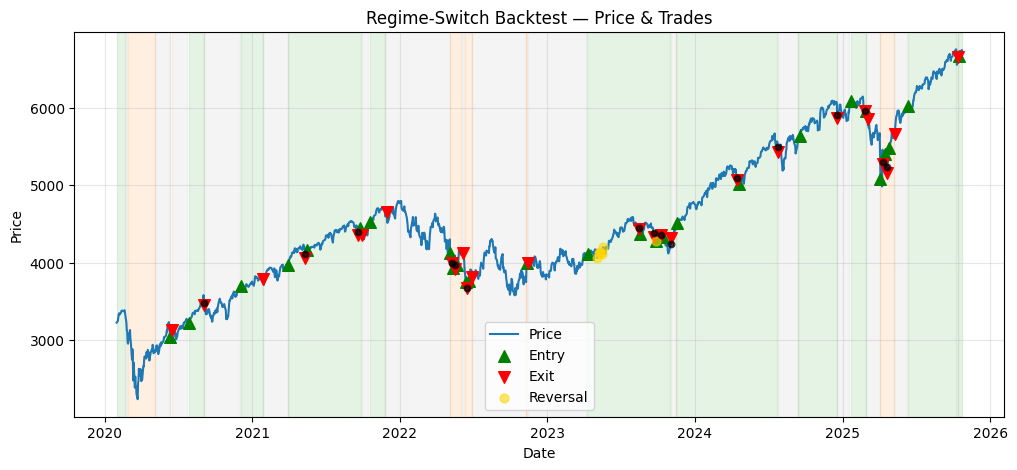

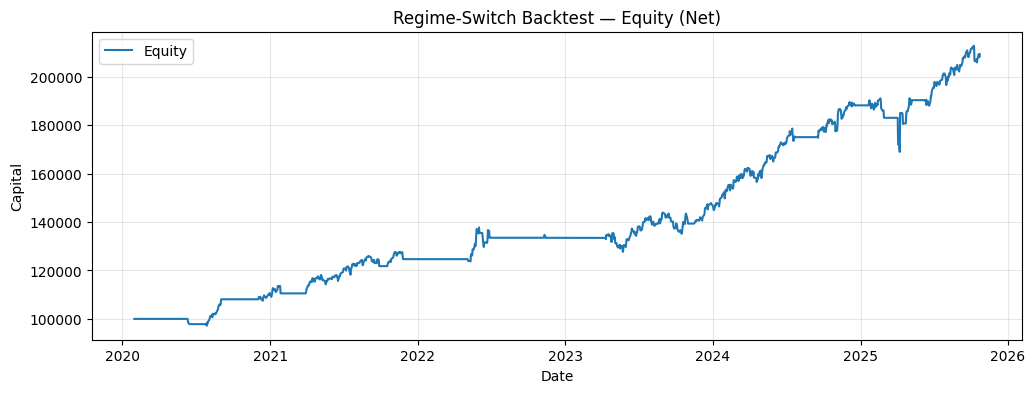

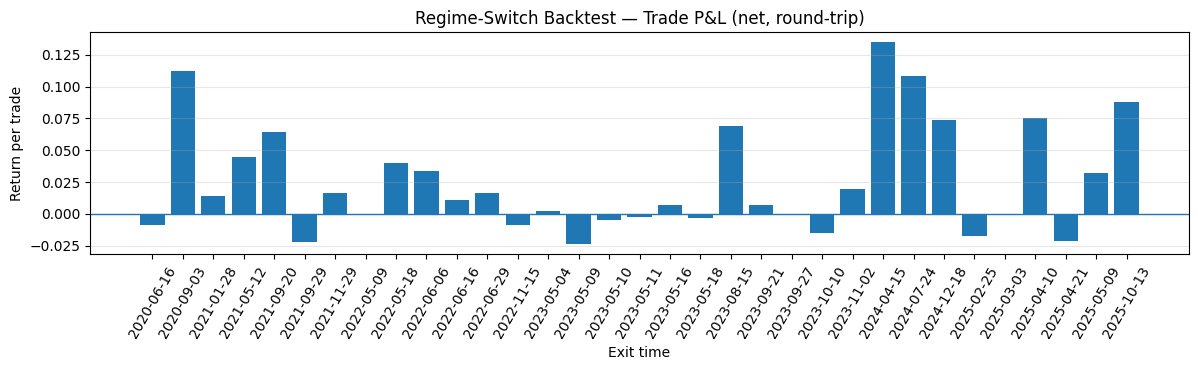

,entry_time,exit_time,side,entry_price,exit_price,ret_trade
0,2020-06-12,2020-06-16,SHORT,3041.310059,3124.739990,-0.008511
1,2020-07-28,2020-09-03,LONG,3218.439941,3455.060059,0.112379
2,2020-12-04,2021-01-28,LONG,3699.120117,3787.379883,0.013760
3,2021-03-31,2021-05-12,LONG,3972.889893,4063.040039,0.044899
4,2021-05-17,2021-09-20,LONG,4163.290039,4357.729980,0.064568


In [149]:
rt = plot_backtest_with_trades(bt, df_out, price_col="Close", show_regime=True)
rt.head()

In [172]:
import numpy as np
import pandas as pd

STRAT_NAME = {1:"Momentum", -1:"MeanReversion", 0:"RandomWalk"}

def _ann(mu, sd, periods=252):
    return (mu/sd)*np.sqrt(periods) if sd>0 else np.nan

def _summary_from_returns(r: pd.Series, init_cap: float) -> pd.Series:
    eq = (1+r).cumprod()*init_cap
    if isinstance(eq.index, pd.DatetimeIndex):
        yrs = max((eq.index[-1]-eq.index[0]).days/365.25, 1e-9)
    else:
        yrs = max(len(eq)/252, 1e-9)
    cagr = (eq.iloc[-1]/eq.iloc[0])**(1/yrs) - 1 if len(eq)>1 else 0.0
    sharpe = _ann(r.mean(), r.std(ddof=0))
    mdd = (eq/eq.cummax()-1).min()
    return pd.Series({"CAGR": cagr, "Sharpe(ann.)": sharpe, "MaxDD": mdd, "TotalRet": eq.iloc[-1]/eq.iloc[0]-1})

def strategy_selected_only_stats(bt: dict, exec_shift: int = 1) -> pd.DataFrame:
    """
    레짐에 따라 '그날 선택된 전략'의 포지션/거래만 남겨 성과를 집계.
    ⇒ RW(관망) 레짐에서는 수익/비용 모두 0이 되며, RW 항목이 음수로 보이는 문제가 사라짐.
    """
    res = bt["result"].copy()
    init_cap = res["equity"].iloc[0]
    ret = res["ret"]

    # 백테스트에서 실제로 쓰인 유효 수수료율(tc) 추정: 총비용/총턴오버
    tc_eff = (res["cost"].sum() / res["turnover"].sum()) if res["turnover"].sum() > 0 else 0.0

    # “신호 발생일” 기준으로 오늘 어떤 전략이 선택됐는지 정렬
    reg_sig_at_signal = res["regime_sig"].shift(exec_shift).astype("Int64")

    out_rows = []
    for k, pos_col in [(-1, "pos_mr"), (0, "pos_rw"), (1, "pos_mom")]:
        # 그 전략이 선택된 날에만 해당 전략 포지션을 살리고, 나머지는 0
        pos_k = res[pos_col].copy().fillna(0.0)
        mask = (reg_sig_at_signal == k)
        pos_active = pos_k.where(mask, 0.0)

        # 그 '선택된 전략' 포지션의 변화분에 대해서만 비용 계산
        dpos_active = pos_active.diff().abs().fillna(pos_active.abs())
        gross = pos_active * ret
        cost  = dpos_active * tc_eff
        net   = gross - cost

        summ = _summary_from_returns(net, init_cap)
        out_rows.append({"Strategy": STRAT_NAME[k], **summ.to_dict()})

    df = pd.DataFrame(out_rows).set_index("Strategy").loc[["MeanReversion","RandomWalk","Momentum"]]
    return df


In [175]:
selected_view = strategy_selected_only_stats(bt, exec_shift=1)
print(selected_view)

                   CAGR  Sharpe(ann.)     MaxDD  TotalRet
Strategy                                                 
MeanReversion  0.002223      0.066476 -0.108825  0.012801
RandomWalk     0.000000           NaN  0.000000  0.000000
Momentum       0.111881      1.358082 -0.063166  0.835709
